In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import plotnine as p9

In [2]:
p9.options.dpi=300
plt.rcParams['svg.fonttype']='none'

In [3]:
import decoupler as dc

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.


In [4]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300)

In [6]:
combined_adata=sc.read_h5ad(ProjectData_dir+'/Anndata/T0T3T5Clone1_combined.h5ad')
#This data has been normalized and log1p, saved in raw

In [19]:
Resist_lineage_adata=combined_adata[combined_adata.obs['is_GENBC0283767']=='GENBC0283767']

In [20]:
mappings={'D0':'Day0','D10':'Day10','D20':'Day20','Resist_clone1':'Day90'}
Resist_lineage_adata.obs['TimePoint']=Resist_lineage_adata.obs['sample'].map(mappings)

Trying to set attribute `.obs` of view, copying.


In [8]:
MSigDB=pd.read_json(ProjectData_dir+'/Anndata/msigdb.v2023.1.Hs.json')

In [9]:
df_MsigDB=MSigDB.transpose()

In [10]:
df_hallmark=df_MsigDB[df_MsigDB.collection=='H']

In [11]:
df_hallmark['geneset_name']=df_hallmark.index

/local/18336806/ipykernel_24255/1445610432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df_hallmark_explode=df_hallmark[['geneSymbols','geneset_name']].explode('geneSymbols',ignore_index=True)

In [13]:
df_hallmark_explode['abbre_name']=df_hallmark_explode['geneset_name'].str.split('MARK_').str[-1]

In [21]:
dc.run_ora(
    mat=Resist_lineage_adata,
    net=df_hallmark_explode,
    source='abbre_name',
    target='geneSymbols',
    verbose=True
)

8771 features of mat are empty, they will be removed.
Running ora on mat with 5203 samples and 27830 targets for 50 sources.


100%|██████████| 5203/5203 [00:14<00:00, 347.87it/s]
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10


In [22]:
acts = dc.get_acts(Resist_lineage_adata, obsm_key='ora_estimate')

In [23]:
# remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [24]:
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 5203 × 50
    obs: 'aliquot', 'cell_bc', 'batch', 'Lineage_assigned', 'sample', 'percent_MAPK', 'nUMI_TopSupLineage', 'nUMI_secondary', 'second/top', 'cell_barcode', 'num_features', 'feature_call', 'num_umis', 'is_GENBC0283767', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'MAPKactivity_score', 'MAPK_scaled', 'TimePoint'
    var: 'mean', 'std'
    obsm: 'ora_estimate', 'ora_pvals'

In [25]:
df = dc.rank_sources_groups(acts, groupby='TimePoint', reference='rest', method='t-test_overestim_var')


In [27]:
n_markers = 10
source_markers = df[(df.meanchange>0.3)&(df.pvals_adj<0.01)].groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'Day0': ['MITOTIC_SPINDLE', 'E2F_TARGETS', 'G2M_CHECKPOINT'],
 'Day10': ['KRAS_SIGNALING_DN', 'BILE_ACID_METABOLISM', 'HEME_METABOLISM'],
 'Day20': ['HEME_METABOLISM',
  'PANCREAS_BETA_CELLS',
  'BILE_ACID_METABOLISM',
  'KRAS_SIGNALING_DN'],
 'Day90': ['EPITHELIAL_MESENCHYMAL_TRANSITION',
  'ALLOGRAFT_REJECTION',
  'GLYCOLYSIS',
  'MTORC1_SIGNALING',
  'APICAL_JUNCTION',
  'MYC_TARGETS_V1',
  'HEDGEHOG_SIGNALING',
  'ANGIOGENESIS',
  'HYPOXIA',
  'INFLAMMATORY_RESPONSE']}

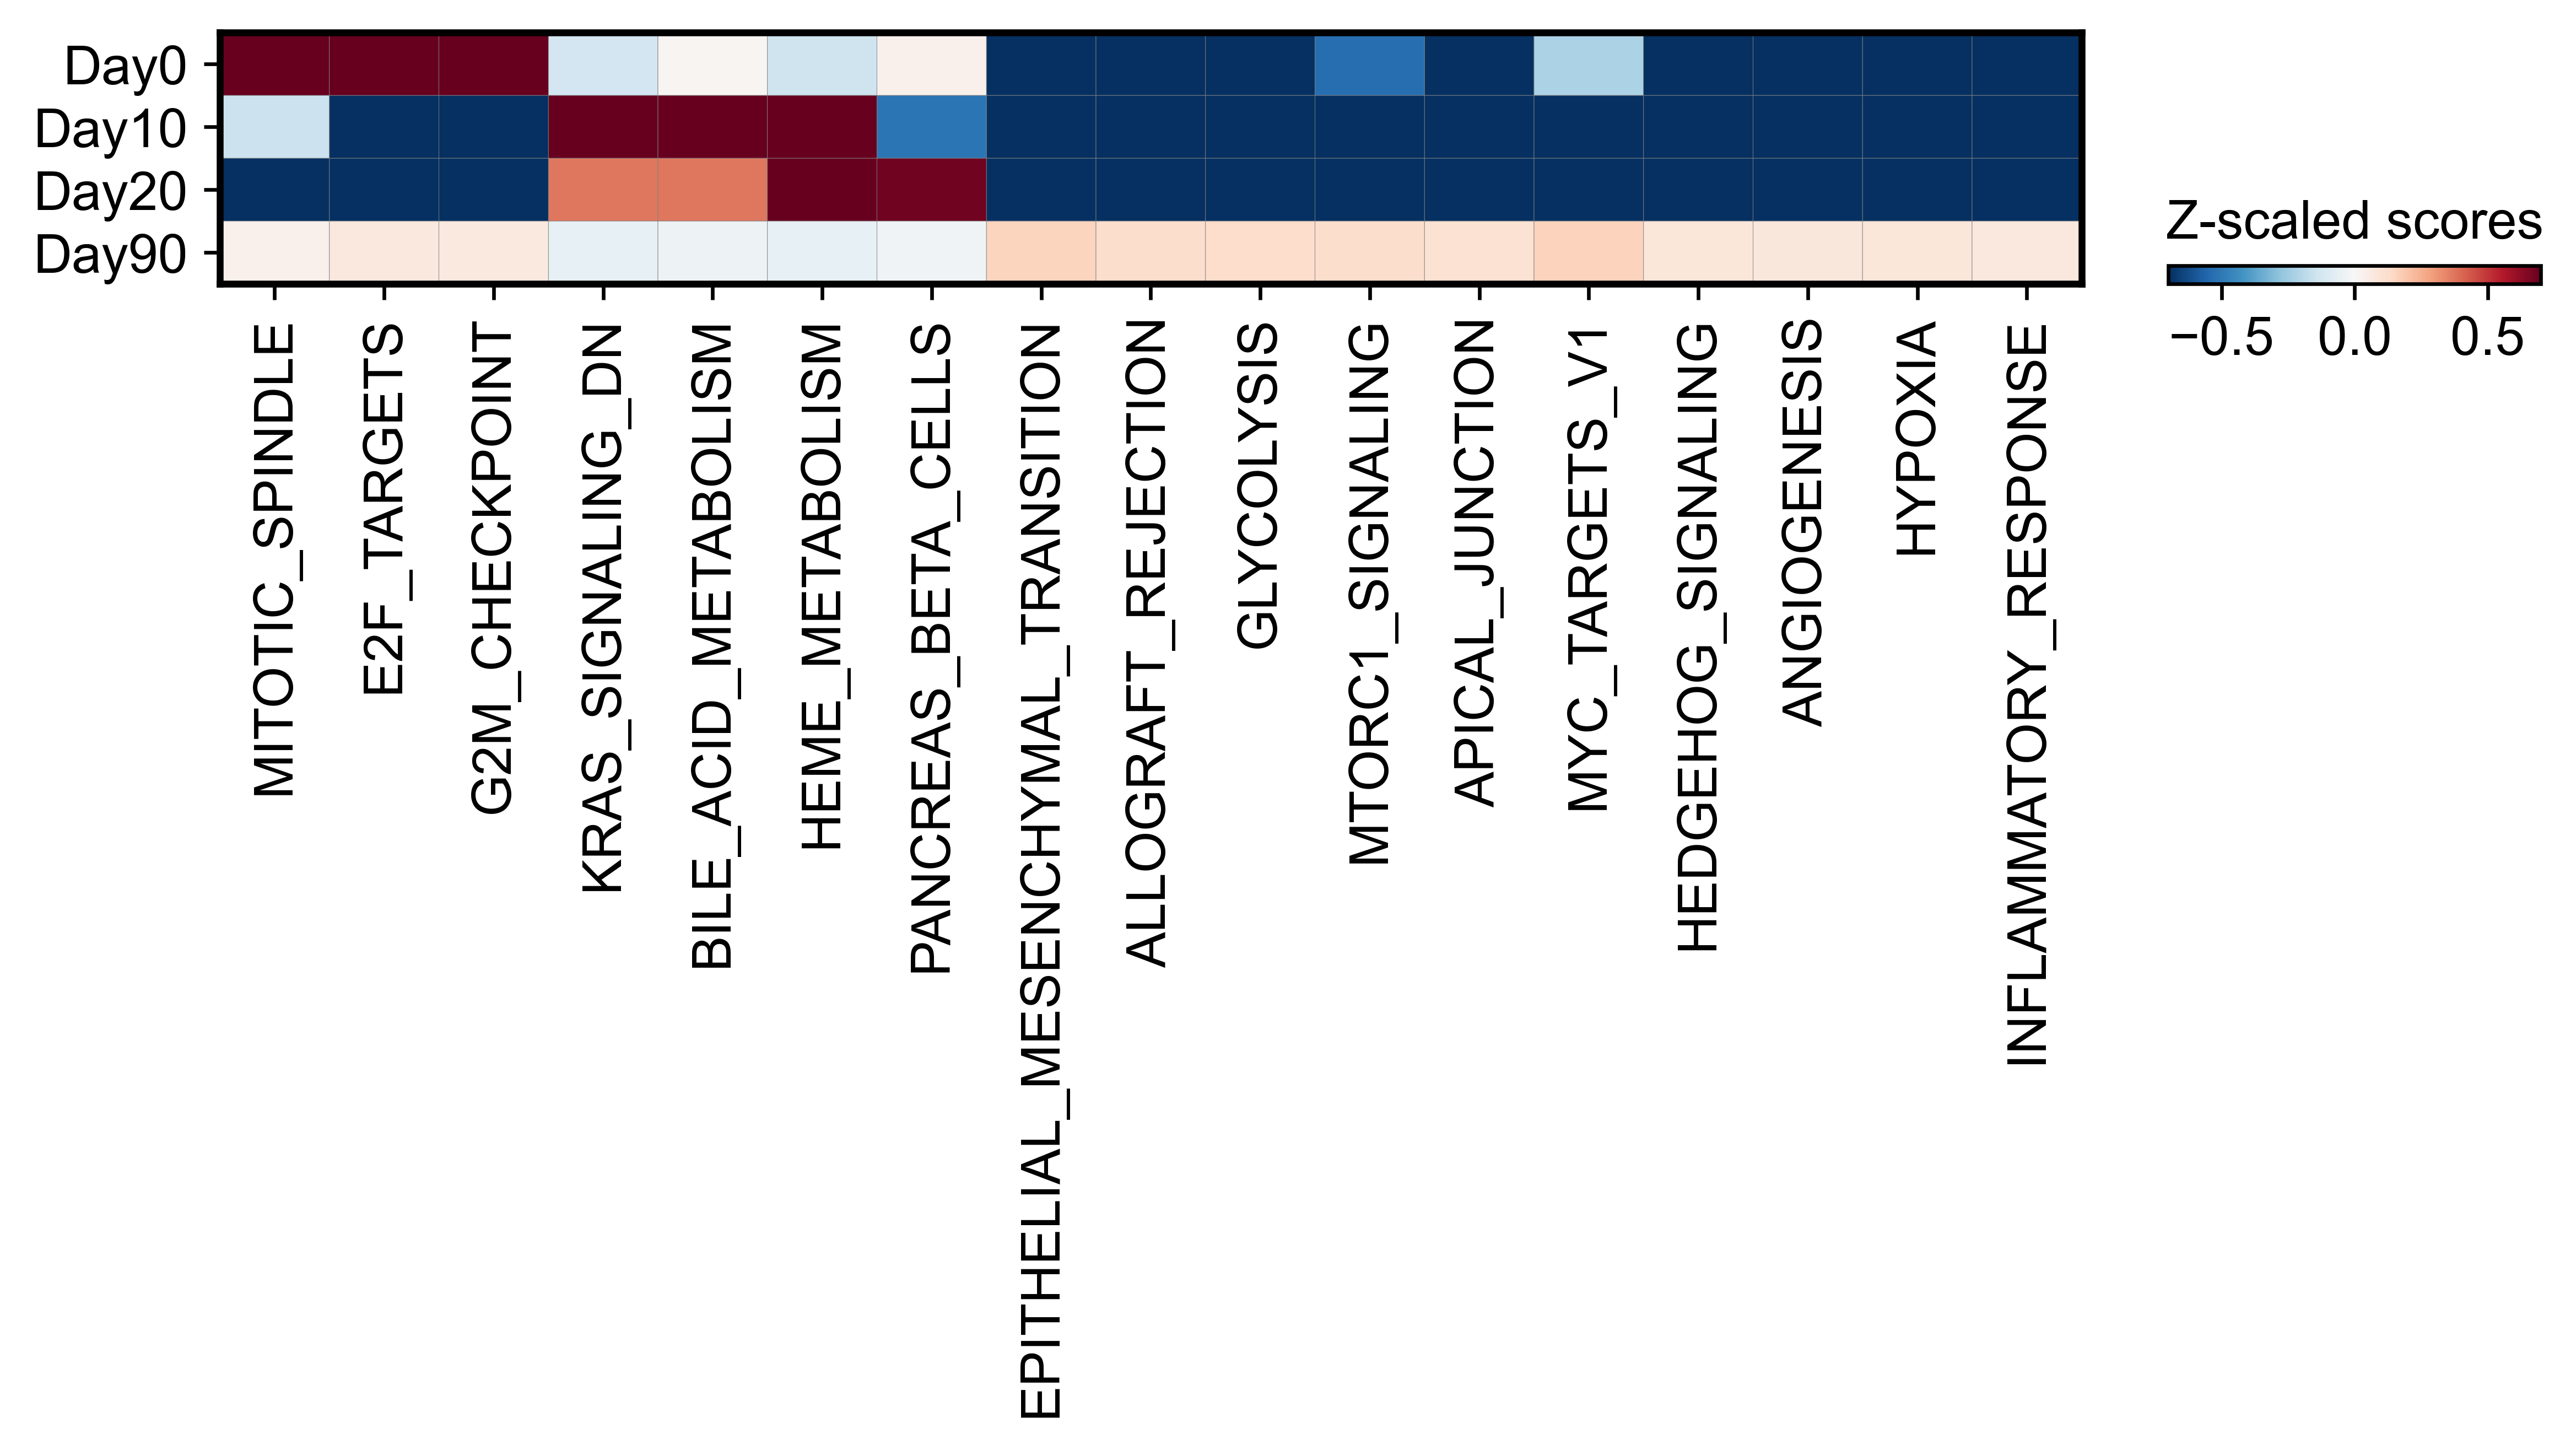

In [28]:
sc.pl.matrixplot(acts, ['MITOTIC_SPINDLE','E2F_TARGETS','G2M_CHECKPOINT','KRAS_SIGNALING_DN','BILE_ACID_METABOLISM','HEME_METABOLISM','PANCREAS_BETA_CELLS','EPITHELIAL_MESENCHYMAL_TRANSITION','ALLOGRAFT_REJECTION','GLYCOLYSIS','MTORC1_SIGNALING','APICAL_JUNCTION','MYC_TARGETS_V1','HEDGEHOG_SIGNALING','ANGIOGENESIS','HYPOXIA','INFLAMMATORY_RESPONSE'], 
                 'TimePoint', dendrogram=False,
                 colorbar_title='Z-scaled scores', vmin=-0.7, vmax=0.7, cmap='RdBu_r',var_group_rotation=0,figsize=[9,1])

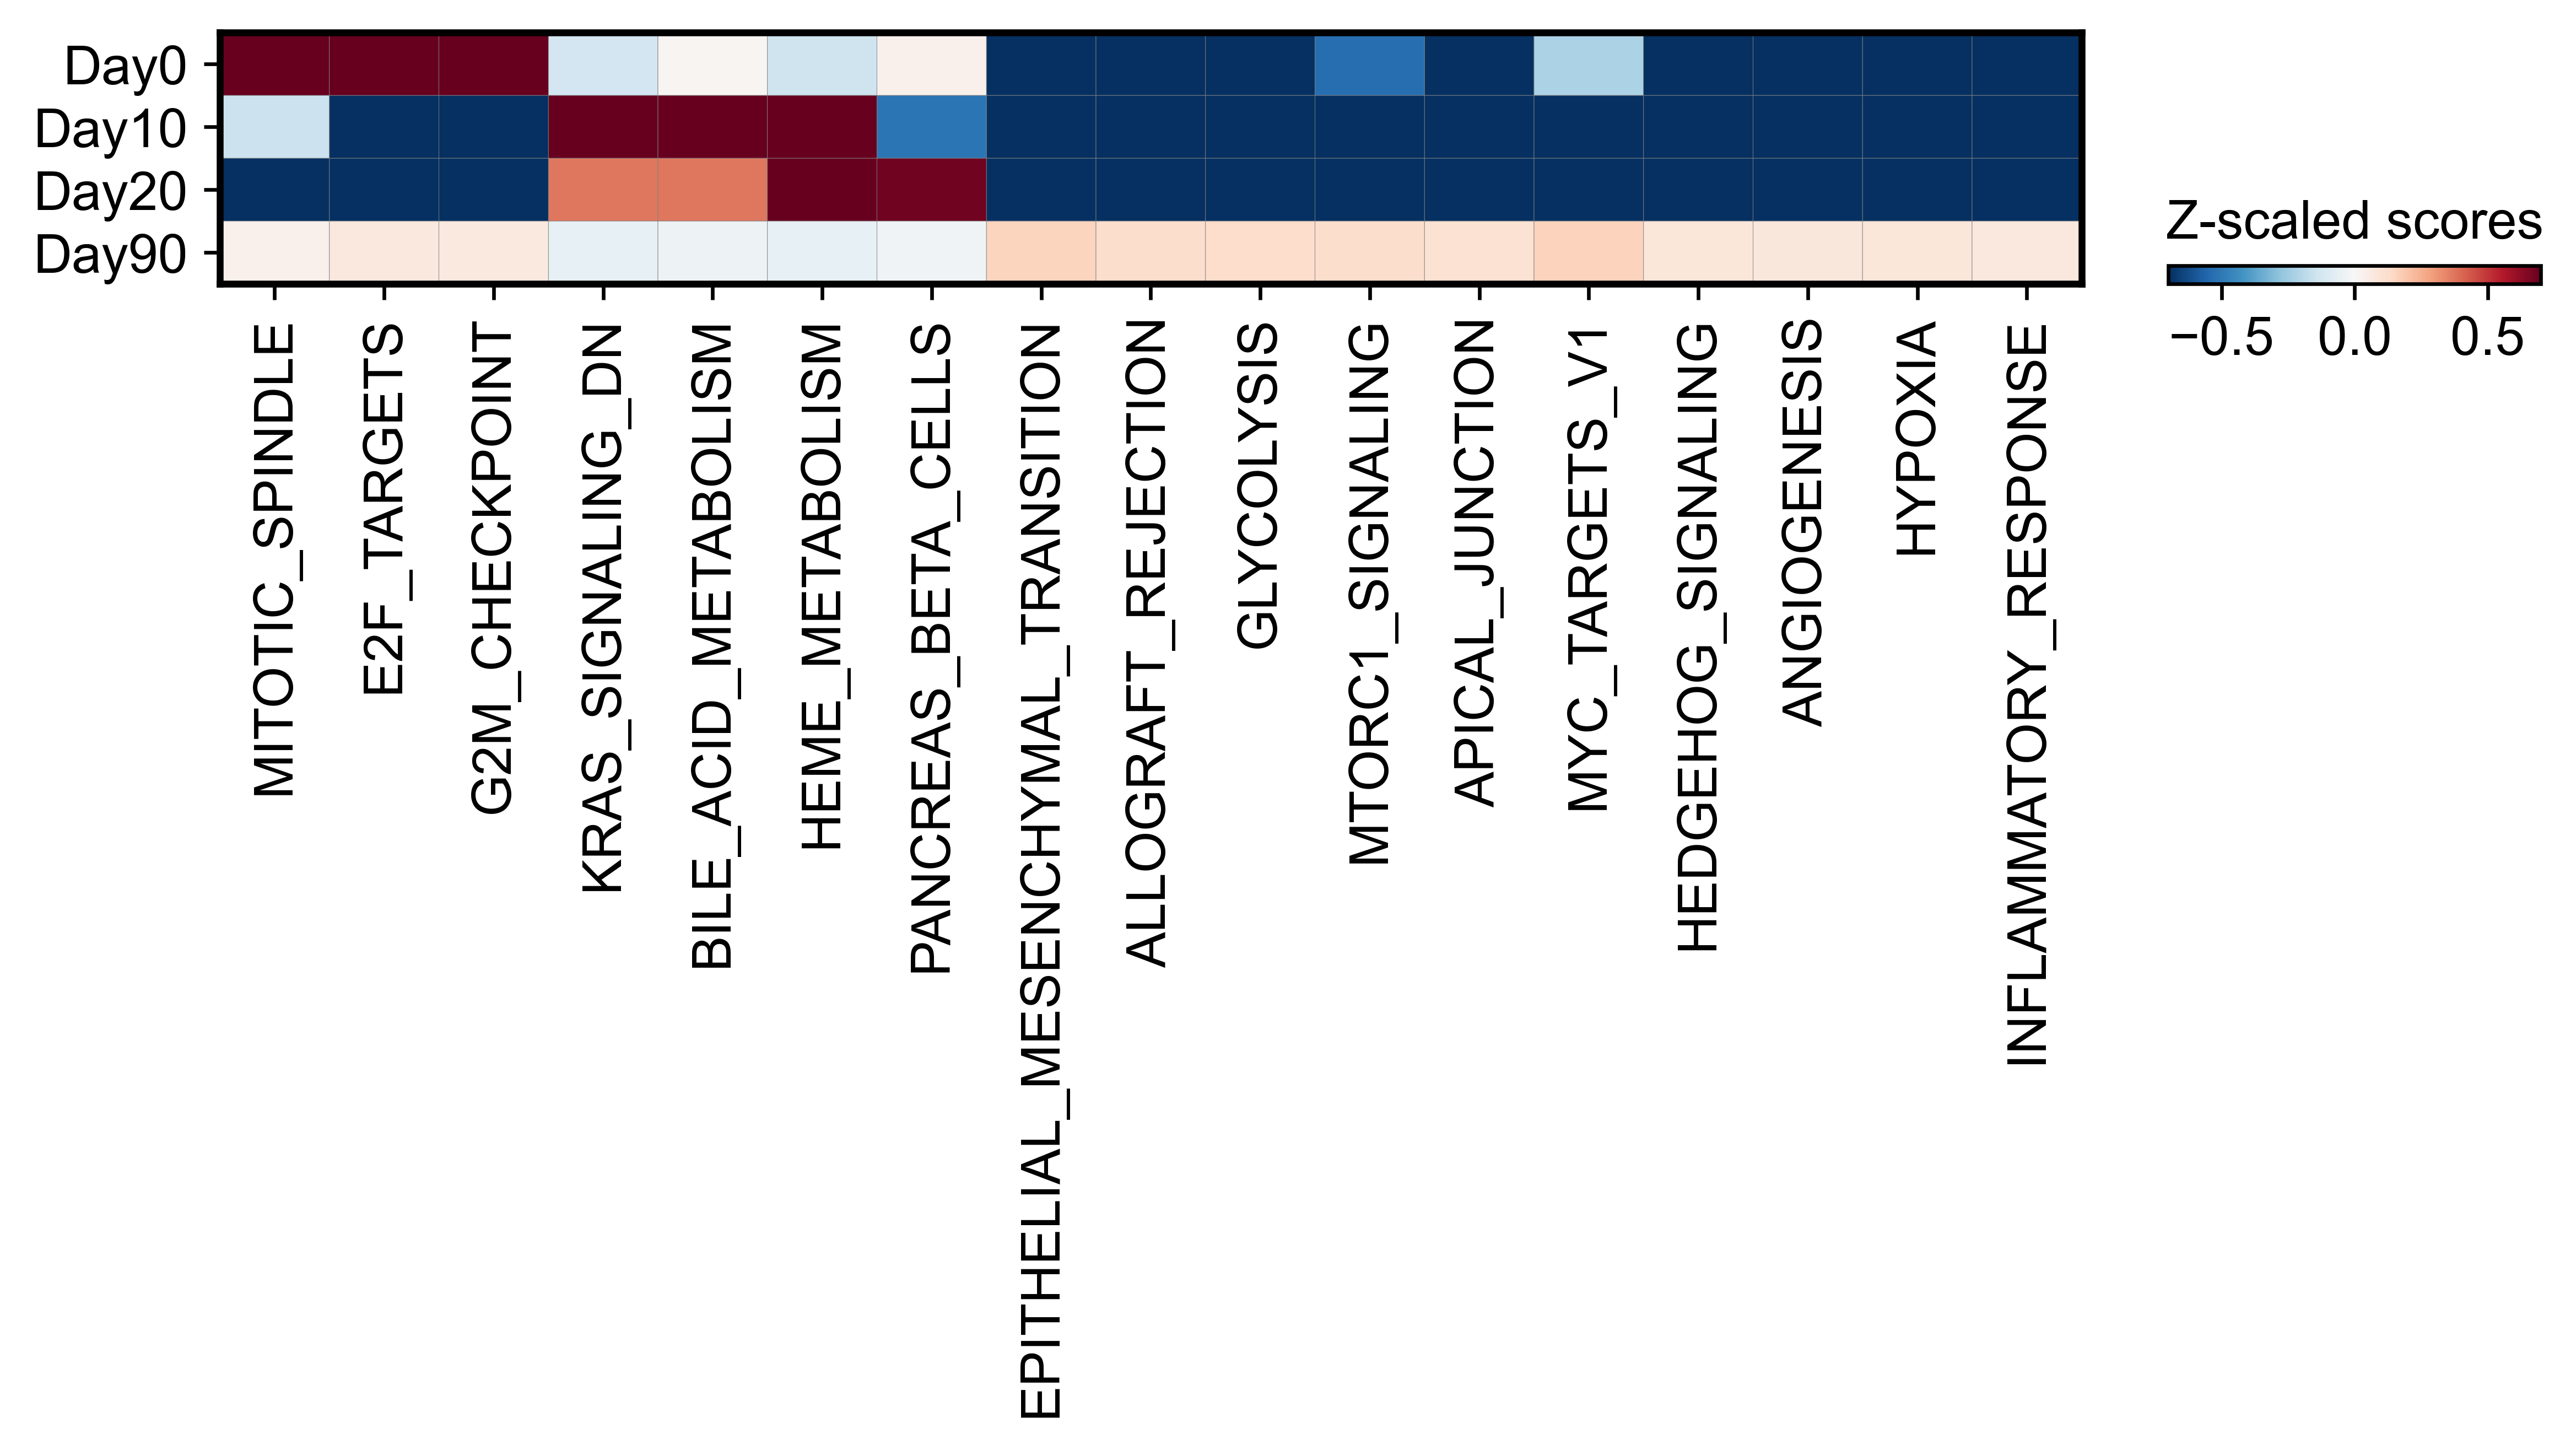

In [32]:
sc.pl.matrixplot(acts, ['MITOTIC_SPINDLE','E2F_TARGETS','G2M_CHECKPOINT','KRAS_SIGNALING_DN','BILE_ACID_METABOLISM','HEME_METABOLISM','PANCREAS_BETA_CELLS','EPITHELIAL_MESENCHYMAL_TRANSITION','ALLOGRAFT_REJECTION','GLYCOLYSIS','MTORC1_SIGNALING','APICAL_JUNCTION','MYC_TARGETS_V1','HEDGEHOG_SIGNALING','ANGIOGENESIS','HYPOXIA','INFLAMMATORY_RESPONSE'], 
                 'TimePoint', dendrogram=False,
                 colorbar_title='Z-scaled scores', vmin=-0.7, vmax=0.7, cmap='RdBu_r',var_group_rotation=0,figsize=[9,1],save='Resistant_Hallmark.svg')
